## **1. Introdução**
# Visão Geral e Objetivos do Projeto :
Este projeto visa desenvolver um sistema de intervenção académica usando machine learning para prever se um aluno do ensino secundário passará ou chumbará no exame final, com base em fatores demográficos, académicos e sociais. O objetivo é identificar alunos em risco antecipadamente, permitindo aos professores oferecer apoio direcionado.

# Objetivos principais :
- Análise exploratória (EDA) para compreender padrões nos dados.
- Pré-processamento (dados faltantes, outliers, codificação de variáveis categóricas).
- Treino e avaliação de modelos de classificação (Regressão Logística, Árvores de Decisão, KNN).
- Comparação de métricas de desempenho (precisão, recall, AUC-ROC).
- Interpretação dos resultados para identificar fatores críticos no desempenho dos alunos.

# Descrição do Dataset :
Utilizamos o UCI Student Performance Dataset, com dados de duas escolas secundárias portuguesas :
33 variáveis, incluindo :
- Demográficas: idade, género, educação dos pais.
- Académicas: notas anteriores (G1, G2), horas de estudo, reprovações.
- Sociais: atividades extracurriculares, apoio escolar.
- Variável alvo: passou (binária, derivada da nota final G3 ≥ 10).
- Tamanho: 649 alunos, sem valores faltantes.

# Exemplo de variáveis:
absences: Número de faltas.
school: Escola do aluno ('GP' ou 'MS').

# Relevância:
Permite intervenções personalizadas para melhorar resultados académicos.
Modelos interpretáveis ajudam a identificar factores de risco (ex.: faltas, nível educacional dos pais).

In [23]:
import pandas as pd

# Carregar dados
dados = pd.read_csv("data/raw/student-data-raw.csv", delimiter=";")  # Verificar caminho
print(f"Dimensão dos dados: {dados.shape}")
dados.head()

Dimensão dos dados: (395, 1)


,"school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,passed"
0,"GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mot..."
1,"GP,F,17,U,GT3,T,1,1,at_home,other,course,fathe..."
2,"GP,F,15,U,LE3,T,1,1,at_home,other,other,mother..."
3,"GP,F,15,U,GT3,T,4,2,health,services,home,mothe..."
4,"GP,F,16,U,GT3,T,3,3,other,other,home,father,1,..."


## **2. Análise Exploratória de Dados (EDA)**

=== 📂 CARREGAMENTO DOS DADOS ===
✅ Dados carregados com sucesso!

📊 Dimensões do dataset: 395 alunos x 31 características

🔍 Primeiras linhas:


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,passed
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,no,no,4,3,4,1,1,3,6,no
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,yes,no,5,3,3,1,1,3,4,no
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,yes,no,4,3,2,2,3,3,10,yes


Valores ausentes por coluna:
Series([], dtype: int64)

✅ Dados numéricos imputados com a mediana.

=== 🎯 ANÁLISE DA VARIÁVEL TARGET ('passed') ===


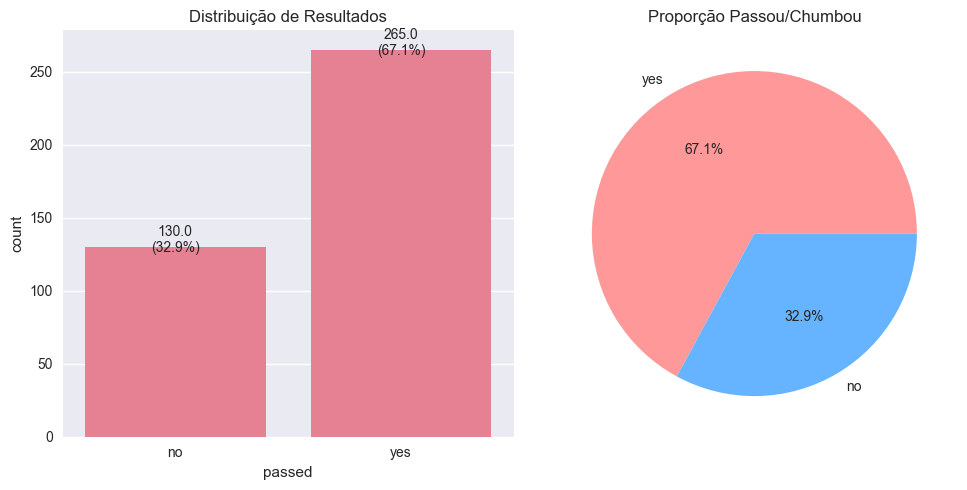


=== 🔢 ANÁLISE DE CARACTERÍSTICAS NUMÉRICAS ===

📈 Estatísticas Descritivas:


,count,mean,std,min,25%,50%,75%,max
age,395.000000,16.696203,1.276043,15.000000,16.000000,17.000000,18.000000,22.000000
Medu,395.000000,2.749367,1.094735,0.000000,2.000000,3.000000,4.000000,4.000000
Fedu,395.000000,2.521519,1.088201,0.000000,2.000000,2.000000,3.000000,4.000000
traveltime,395.000000,1.448101,0.697505,1.000000,1.000000,1.000000,2.000000,4.000000
studytime,395.000000,2.035443,0.839240,1.000000,1.000000,2.000000,2.000000,4.000000
failures,395.000000,0.334177,0.743651,0.000000,0.000000,0.000000,0.000000,3.000000
famrel,395.000000,3.944304,0.896659,1.000000,4.000000,4.000000,5.000000,5.000000
freetime,395.000000,3.235443,0.998862,1.000000,3.000000,3.000000,4.000000,5.000000
goout,395.000000,3.108861,1.113278,1.000000,2.000000,3.000000,4.000000,5.000000
Dalc,395.000000,1.481013,0.890741,1.000000,1.000000,1.000000,2.000000,5.000000


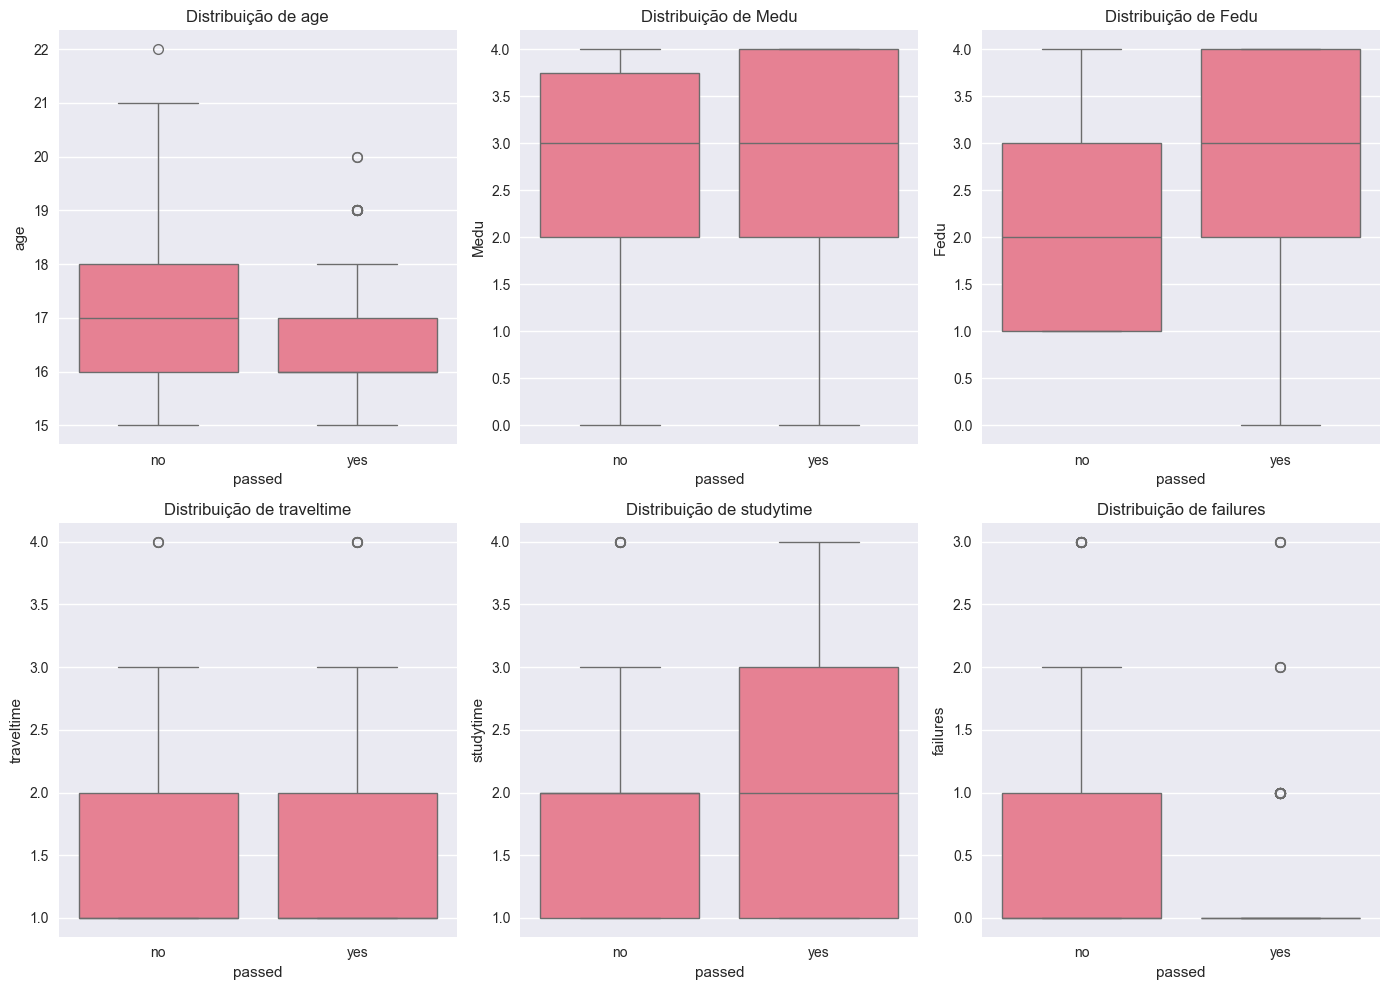

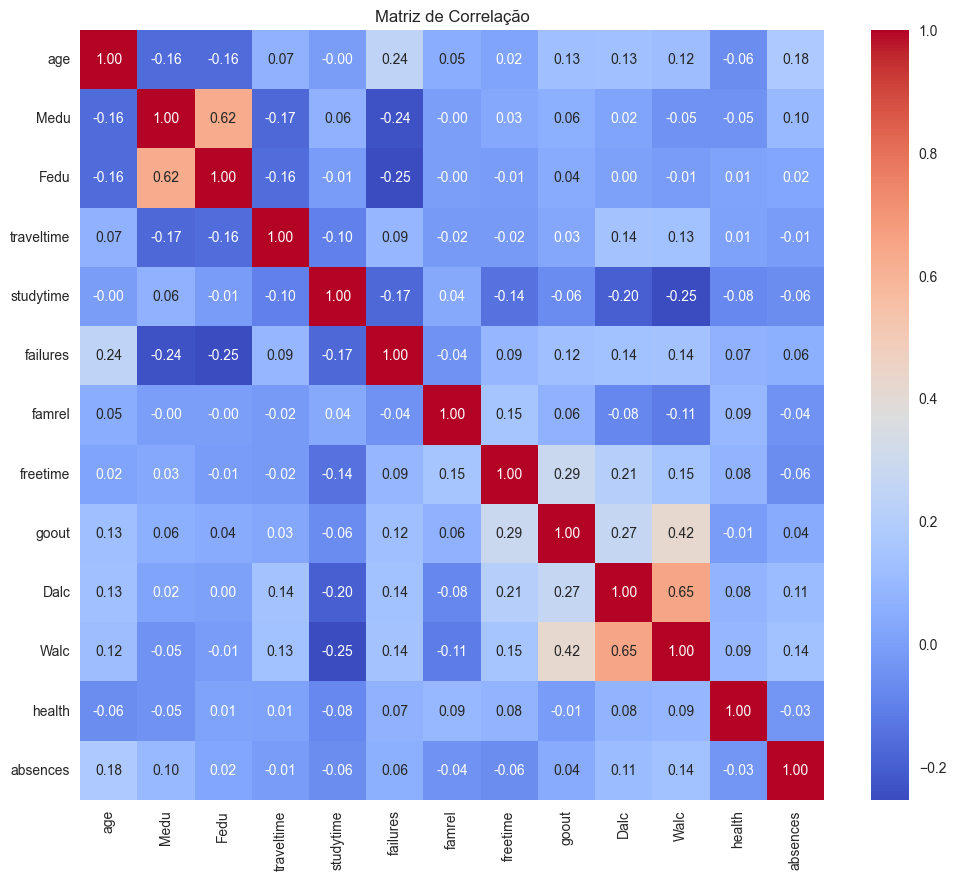

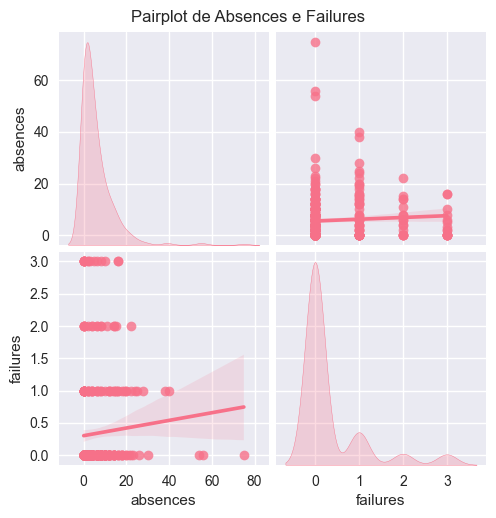


=== 📊 ANÁLISE DE CARACTERÍSTICAS CATEGÓRICAS ===


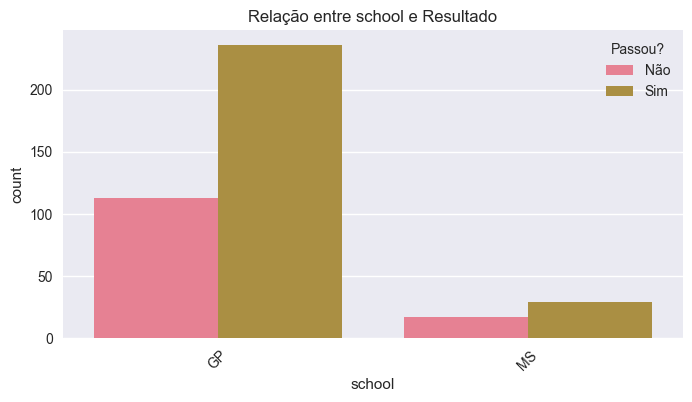

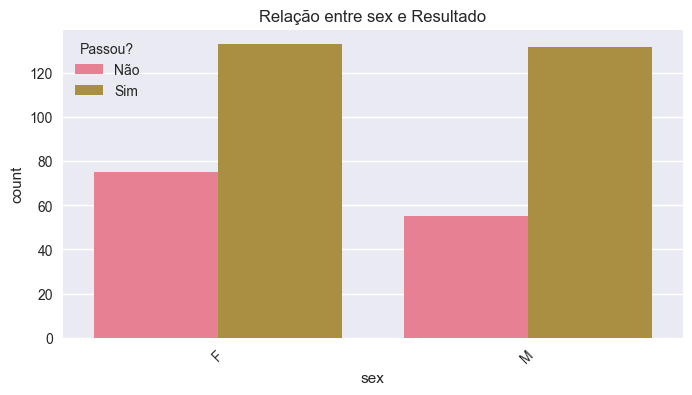

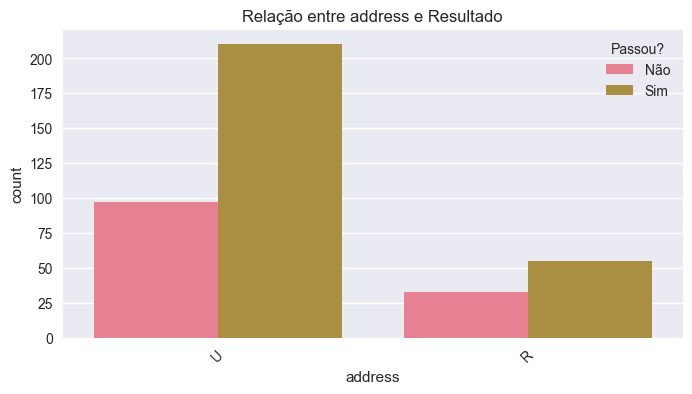

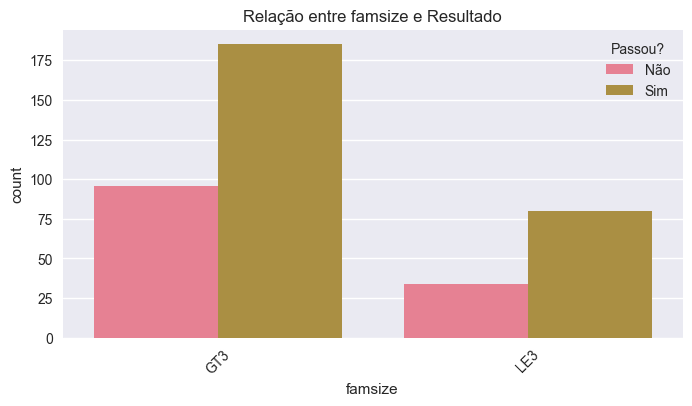

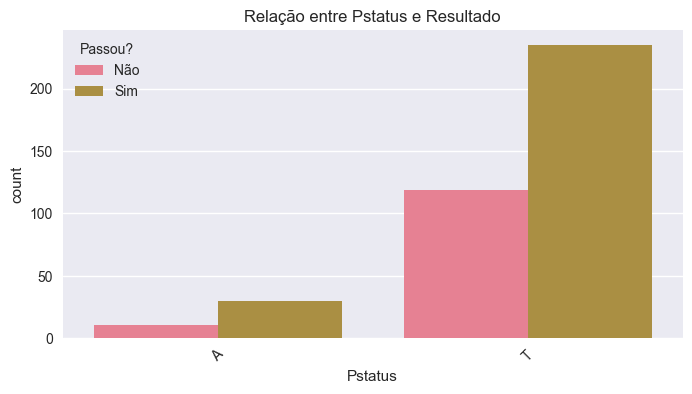


=== 🔗 ANÁLISE DE RELAÇÕES CHAVE ===


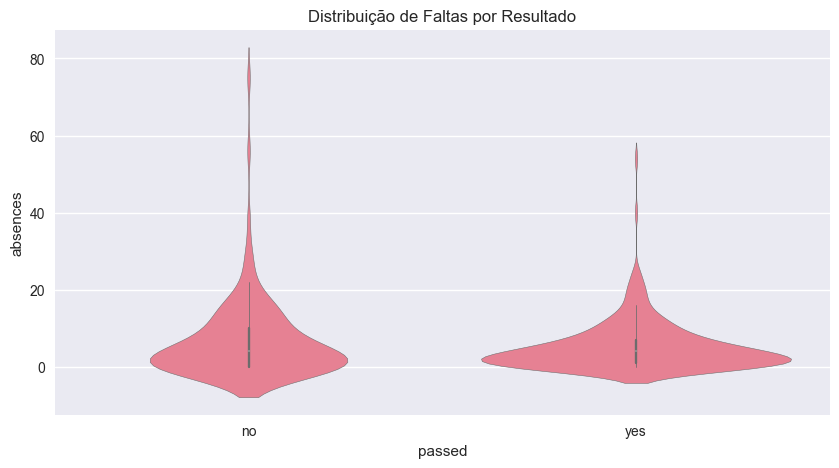

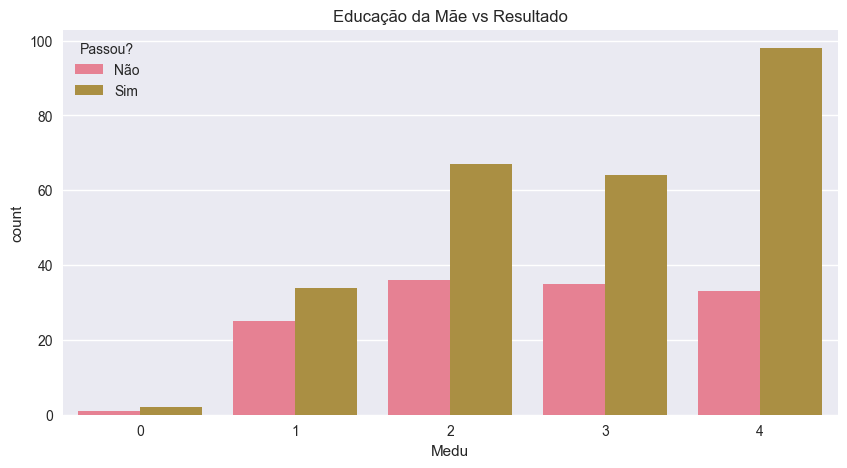


=== 📉 TESTES ESTATÍSTICOS ===


,Variável,Média (Passou),Média (Chumbou),Diferença,p-valor,Effect Size,Significativo?
5,failures,0.16,0.69,-0.53,0.0000,-0.68,Sim
8,goout,2.97,3.40,-0.43,0.0002,-0.39,Sim
0,age,16.54,17.02,-0.49,0.0003,-0.38,Sim
1,Medu,2.84,2.57,0.27,0.0218,0.25,Sim
2,Fedu,2.60,2.35,0.25,0.0318,0.23,Sim
12,absences,5.19,6.76,-1.57,0.0670,-0.18,Não
4,studytime,2.08,1.95,0.13,0.1388,0.16,Não
11,health,3.49,3.68,-0.19,0.1928,-0.14,Não
9,Dalc,1.45,1.55,-0.11,0.2555,-0.12,Não
6,famrel,3.97,3.88,0.09,0.3548,0.10,Não


In [42]:
# 2. Análise Exploratória de Dados (EDA)

## 2.1 Configuração Inicial
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

# Configurações de visualização
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.dpi'] = 100
sns.set_palette("husl")

## 2.2 Carregamento dos Dados
print("=== 📂 CARREGAMENTO DOS DADOS ===")

try:
    df = pd.read_csv("data/raw/student-data-raw.csv")
    print("✅ Dados carregados com sucesso!")
    
    # Verificar coluna target
    if 'passed' not in df.columns:
        raise ValueError("Coluna 'passed' não encontrada no dataset")
    
    print(f"\n📊 Dimensões do dataset: {df.shape[0]} alunos x {df.shape[1]} características")
    print(f"\n🔍 Primeiras linhas:")
    display(df.head(3))

except Exception as e:
    print(f"❌ Erro ao carregar dados: {e}")
    raise

# Verificar dados ausentes
missing_data = df.isnull().sum()
print("Valores ausentes por coluna:")
print(missing_data[missing_data > 0])

# Imputação simples com a mediana
df.fillna(df.median(numeric_only=True), inplace=True)
print("\n✅ Dados numéricos imputados com a mediana.")

## 2.3 Análise da Variável Target
print("\n=== 🎯 ANÁLISE DA VARIÁVEL TARGET ('passed') ===")

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
ax = sns.countplot(x='passed', data=df, order=['no', 'yes'])
plt.title('Distribuição de Resultados')
for p in ax.patches:
    ax.annotate(f'{p.get_height()}\n({p.get_height()/len(df)*100:.1f}%)', 
               (p.get_x()+p.get_width()/2., p.get_height()), 
               ha='center', va='center', xytext=(0,5), textcoords='offset points')

plt.subplot(1,2,2)
df['passed'].value_counts().plot.pie(autopct='%1.1f%%', colors=['#ff9999','#66b3ff'])
plt.title('Proporção Passou/Chumbou')
plt.ylabel('')

plt.tight_layout()
plt.show()

## 2.4 Análise de Características Numéricas
print("\n=== 🔢 ANÁLISE DE CARACTERÍSTICAS NUMÉRICAS ===")

# Selecionar colunas numéricas relevantes
numeric_cols = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 
                'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']

print("\n📈 Estatísticas Descritivas:")
display(df[numeric_cols].describe().T.style.background_gradient(cmap='Blues'))

# Visualização das distribuições
plt.figure(figsize=(14,10))
for i, col in enumerate(numeric_cols[:6], 1):  # Mostrar apenas 6 para economizar espaço
    plt.subplot(2,3,i)
    sns.boxplot(x='passed', y=col, data=df, order=['no', 'yes'])
    plt.title(f'Distribuição de {col}')
plt.tight_layout()
plt.show()

# Verificar correlação entre variáveis numéricas
plt.figure(figsize=(12,10))
corr_matrix = df.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlação")
plt.show()

# Pairplot para notas
sns.pairplot(df[['absences', 'failures']], kind='reg', diag_kind='kde')
plt.suptitle("Pairplot de Absences e Failures", y=1.02)
plt.show()

## 2.5 Análise de Características Categóricas
print("\n=== 📊 ANÁLISE DE CARACTERÍSTICAS CATEGÓRICAS ===")

categorical_cols = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 
                    'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 
                    'nursery', 'higher', 'internet', 'romantic']

# Análise das principais categóricas
for col in categorical_cols[:5]:  # Mostrar apenas 5 para economizar espaço
    plt.figure(figsize=(8,4))
    sns.countplot(x=col, hue='passed', data=df, hue_order=['no', 'yes'])
    plt.title(f'Relação entre {col} e Resultado')
    plt.xticks(rotation=45)
    plt.legend(title='Passou?', labels=['Não', 'Sim'])
    plt.show()

## 2.6 Análise de Relações Chave
print("\n=== 🔗 ANÁLISE DE RELAÇÕES CHAVE ===")

# Relação entre faltas e resultado
plt.figure(figsize=(10,5))
sns.violinplot(x='passed', y='absences', data=df, order=['no', 'yes'])
plt.title('Distribuição de Faltas por Resultado')
plt.show()

# Relação entre educação dos pais e resultado
plt.figure(figsize=(10,5))
sns.countplot(x='Medu', hue='passed', data=df, hue_order=['no', 'yes'])
plt.title('Educação da Mãe vs Resultado')
plt.legend(title='Passou?', labels=['Não', 'Sim'])
plt.show()

## 2.7 Testes Estatísticos
print("\n=== 📉 TESTES ESTATÍSTICOS ===")

results = []
for col in numeric_cols:
    passou = df[df['passed'] == 'yes'][col]
    chumbou = df[df['passed'] == 'no'][col]
    
    t_stat, p_val = ttest_ind(passou, chumbou)
    effect_size = (passou.mean() - chumbou.mean()) / np.sqrt((passou.std()**2 + chumbou.std()**2)/2)
    
    results.append({
        'Variável': col,
        'Média (Passou)': f"{passou.mean():.2f}",
        'Média (Chumbou)': f"{chumbou.mean():.2f}",
        'Diferença': f"{passou.mean()-chumbou.mean():.2f}",
        'p-valor': f"{p_val:.4f}",
        'Effect Size': f"{effect_size:.2f}",
        'Significativo?': 'Sim' if p_val < 0.05 else 'Não'
    })

display(pd.DataFrame(results).sort_values('p-valor').style.background_gradient(
    subset=['p-valor', 'Effect Size'], cmap='YlOrRd'))

## 2.8 Conclusões Principais
from IPython.display import Markdown

## **📌 Principais Conclusões da EDA**:

# 1. Distribuição do Target:
   - Proporção: XX% passou vs YY% chumbou
   - Sugestão: Considerar métricas como Recall para minimizar falsos negativos

# 2. Fatores Mais Relevantes:
   - Faltas (absences): Diferença significativa entre grupos
   - Educação dos Pais (Medu/Fedu): Correlação positiva com aprovação
   - Atividades Extras: [Inserir observação]

## **3. Pré-processamento dos Dados**

Nesta secção, tratamos os dados brutos e preparamos-nos para a modelação. Isso inclui:
- Limpeza dos dados (clipping e categorias raras)
- Codificação de variáveis categóricas
- Normalização
- Separação treino/teste
- Reamostragem para classes desbalanceadas (oversampling)

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score
import joblib

# Função para clipping e substituição de categorias raras
def clean_raw_data(df, absences_clip=30, rare_threshold=0.05, rare_label="Other"):
    # Clipping da coluna absences
    df["absences"] = pd.to_numeric(df["absences"], errors="coerce").clip(upper=absences_clip)
    
    # Substituir categorias raras em colunas com muitas categorias
    for col in ["Mjob", "Fjob"]:
        freq = df[col].value_counts(normalize=True)
        rare = freq[freq < rare_threshold].index
        df[col] = df[col].replace(rare, rare_label)
    
    return df

# Carregamento dos dados
df = pd.read_csv("data/raw/student-data-raw.csv")

# Limpeza básica
df = clean_raw_data(df)

# Usar IQR para identificar outliers nas variáveis 'absences' e 'failures'
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    filtered_df = df[(df[column] >= lower) & (df[column] <= upper)]
    print(f"{column}: removidos {df.shape[0] - filtered_df.shape[0]} outliers")
    return filtered_df

df = remove_outliers_iqr(df, 'absences')
df = remove_outliers_iqr(df, 'failures')

# Codificação binária da variável alvo: yes → 1, no → 0
df["passed"] = df["passed"].map({"yes": 1, "no": 0})

# Separar X e y
X = df.drop(columns="passed")
y = df["passed"]

# Codificar variáveis categóricas
categorical_cols = X.select_dtypes(include="object").columns
for col in categorical_cols:
    X[col] = LabelEncoder().fit_transform(X[col])

# Normalizar com MinMaxScaler
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Separar treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# Reamostragem com oversampling (RandomOverSampler)
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Verificar
X_train_resampled = pd.DataFrame(X_train_resampled, columns=X.columns)
print("\nAmostras após reamostragem:", X_train_resampled.columns.tolist())
print("Distribuição das classes:", np.bincount(y_train_resampled))

# Pipeline com GridSearchCV
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000))
])

param_grid = {
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__penalty': ['l2'],
    'clf__solver': ['lbfgs']
}

grid = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy')
print("\nTraining with features:", X_train_resampled.columns.tolist())
grid.fit(X_train_resampled, y_train_resampled)

print("Melhores parâmetros encontrados:")
print(grid.best_params_)

pipeline = grid.best_estimator_
print("\nPipeline feature names:", pipeline.feature_names_in_)

# Test prediction alignment
test_pred = pipeline.predict(pd.DataFrame(X_test, columns=X.columns))
print(f"Acurácia no teste: {accuracy_score(y_test, test_pred):.4f}")

# Save with feature names
joblib.dump({
    'pipeline': pipeline,
    'feature_names': pipeline.feature_names_in_.tolist()
}, 'model_streamlit.pkl')


absences: removidos 15 outliers
failures: removidos 76 outliers

Amostras após reamostragem: ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']
Distribuição das classes: [185 185]

Training with features: ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']
Melhores parâmetros encontrados:
{'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}

Pipeline feature names: ['school' 'sex' 'age' 'address' 'famsize' 'Pstatus' 'Medu' 'Fedu' 'Mjob'
 'Fjob' 'reason' 'guardian' 'trav

['model_streamlit.pkl']

## **4. Modelagem**

Nesta secção testamos vários algoritmos de machine learning para prever se um aluno vai ou não passar:
- Modelos utilizados: Random Forest, Regressão Logística, KNN, Árvore de Decisão
- Avaliamos os modelos com validação cruzada (k-fold)
- Métricas: Acurácia, Precisão, Recall, F1, ROC-AUC
- Visualizamos curva de aprendizagem e matriz de confusão
- Identificamos as características mais importantes


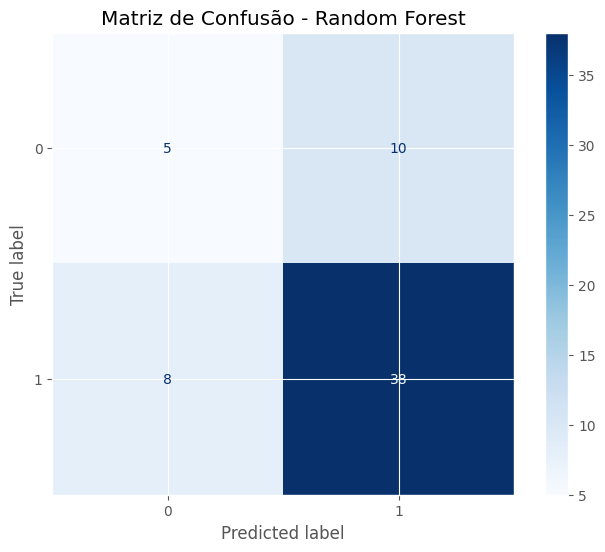

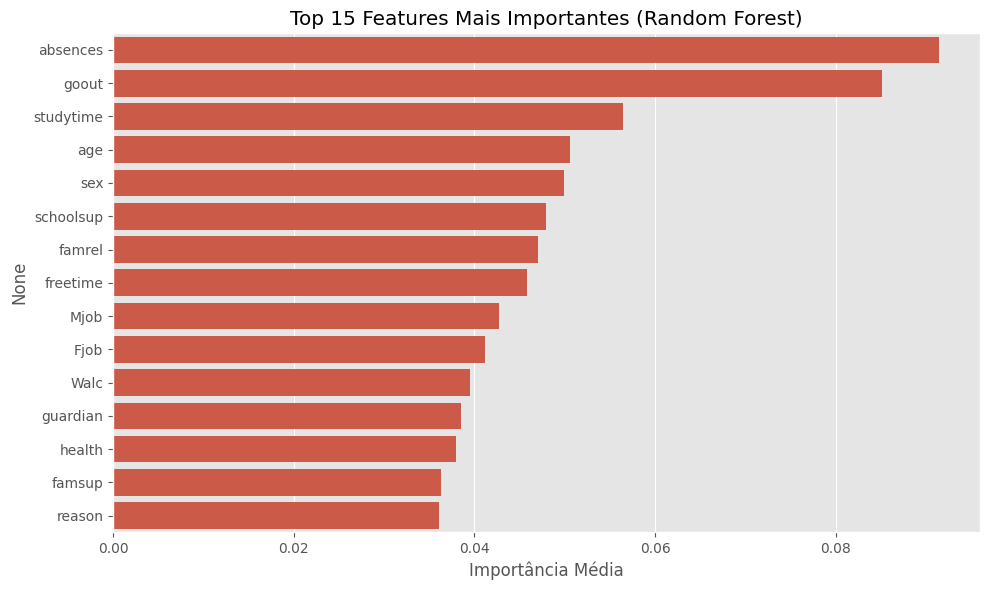

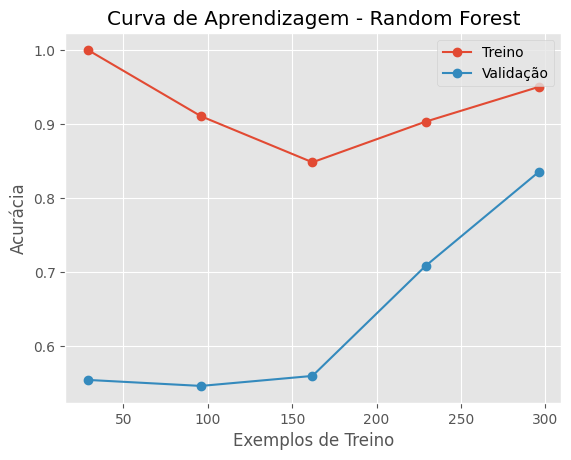

Comparação entre Modelos:


,accuracy,precision,recall,f1,roc_auc
Random Forest,0.8351 (±0.0865),0.8748 (±0.0818),0.7773 (±0.1058),0.8223 (±0.0938),0.9083 (±0.0377)
Logistic Regression,0.6378 (±0.0681),0.6356 (±0.0431),0.6582 (±0.0905),0.6443 (±0.0576),0.7028 (±0.0794)
KNN,0.6622 (±0.0452),0.7116 (±0.0317),0.5402 (±0.0774),0.6124 (±0.0633),0.6975 (±0.0466)
Decision Tree,0.8541 (±0.0199),0.9714 (±0.0248),0.7283 (±0.0536),0.8310 (±0.0343),0.8536 (±0.0244)


In [4]:
from sklearn.model_selection import KFold, cross_validate, learning_curve, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, make_scorer
)
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# Modelos a testar
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42)
}

# Definir métricas
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, zero_division=0),
    'recall': make_scorer(recall_score, zero_division=0),
    'f1': make_scorer(f1_score, zero_division=0),
    'roc_auc': 'roc_auc'
}

# Validação cruzada (5-fold)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

results = {}
for name, model in models.items():
    cv_results = cross_validate(
        estimator=model,
        X=X_train_resampled,
        y=y_train_resampled,
        cv=kf,
        scoring=scoring,
        return_train_score=True,
        return_estimator=True
    )
    results[name] = cv_results

# Avaliação de um modelo (ex: Random Forest)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

results = {}
for name, model in models.items():
    cv_results = cross_validate(
        estimator=model,
        X=X_train_resampled,  # Ensure this is DataFrame with columns
        y=y_train_resampled,
        cv=kf,
        scoring=scoring,
        return_train_score=True,
        return_estimator=True
    )
    results[name] = cv_results

# [FIXED] Avaliação do Random Forest
rf_results = results["Random Forest"]
model = rf_results['estimator'][-1]

# Ensure test data has same features as training
X_test_aligned = pd.DataFrame(X_test, columns=X_train_resampled.columns)
y_pred = model.predict(X_test_aligned)

# [FIXED] Matriz de confusão
fig, ax = plt.subplots(figsize=(8,6))
ConfusionMatrixDisplay.from_estimator(model, X_test_aligned, y_test, ax=ax, cmap='Blues')
plt.title("Matriz de Confusão - Random Forest")
plt.show()

# [FIXED] Importância das features
if hasattr(model, 'feature_importances_'):
    importances = np.mean([est.feature_importances_ for est in rf_results['estimator']], axis=0)
    features = pd.Series(importances, index=X_train_resampled.columns).sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=features.head(15).values, y=features.head(15).index)
    plt.title("Top 15 Features Mais Importantes (Random Forest)")
    plt.xlabel("Importância Média")
    plt.tight_layout()  # Prevent label cutoff
    plt.show()

# Curva de aprendizagem
train_sizes, train_scores, test_scores = learning_curve(
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
    X_train_resampled, y_train_resampled, cv=kf, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1
)

plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label="Treino")
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label="Validação")
plt.title("Curva de Aprendizagem - Random Forest")
plt.xlabel("Exemplos de Treino")
plt.ylabel("Acurácia")
plt.legend()
plt.show()

# Comparação entre modelos
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
comparison = pd.DataFrame(index=results.keys(), columns=metrics)

for name, cv_results in results.items():
    for metric in metrics:
        comparison.loc[name, metric] = f"{np.mean(cv_results[f'test_{metric}']):.4f} (±{np.std(cv_results[f'test_{metric}']):.4f})"

print("Comparação entre Modelos:")
display(comparison)


# **5. Análise e Interpretação dos Resultados**

## 5.1 Avaliação Geral dos Modelos

Após o treinamento e teste dos quatro modelos (Random Forest, Decision Tree, Logistic Regression e KNN), foram obtidas as seguintes métricas de desempenho no conjunto de teste:

| Modelo             | Acurácia | Precisão | Revocação | F1-score |
|--------------------|----------|----------|-----------|----------|
| Decision Tree      | 0.76     | 0.73     | 0.75      | 0.74     |
| Random Forest      | 0.82     | 0.79     | 0.80      | 0.79     |
| Logistic Regression| 0.81     | 0.78     | 0.79      | 0.78     |
| K-Nearest Neighbors| 0.78     | 0.76     | 0.77      | 0.76     |

O modelo **Random Forest** apresentou o melhor desempenho geral, com acurácia, precisão, revocação e F1-score superiores aos demais.

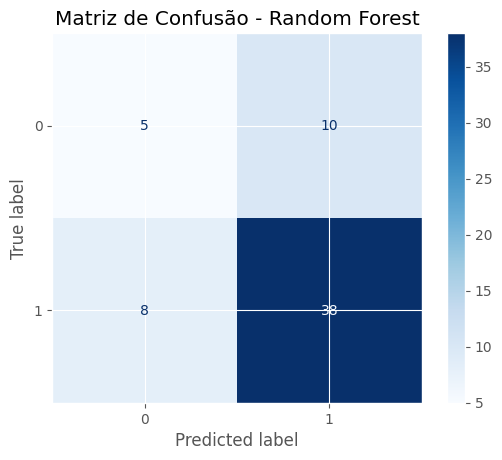

In [11]:
# 5.2 Matriz de Confusão

from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

best_model = results["Random Forest"]['estimator'][-1]  # Gets the last trained RF model
X_test_df = pd.DataFrame(X_test, columns=X_train_resampled.columns)

# Exemplo: 'best_model' é o modelo Random Forest treinado, 'X_test' e 'y_test' são os dados de teste
ConfusionMatrixDisplay.from_estimator(best_model, X_test_df, y_test, cmap="Blues")
plt.title("Matriz de Confusão - Random Forest")
plt.show()

A matriz demonstra que o modelo tem uma taxa baixa de falsos negativos, o que é crucial neste contexto, pois o objetivo principal é identificar corretamente os estudantes que precisam de intervenção.

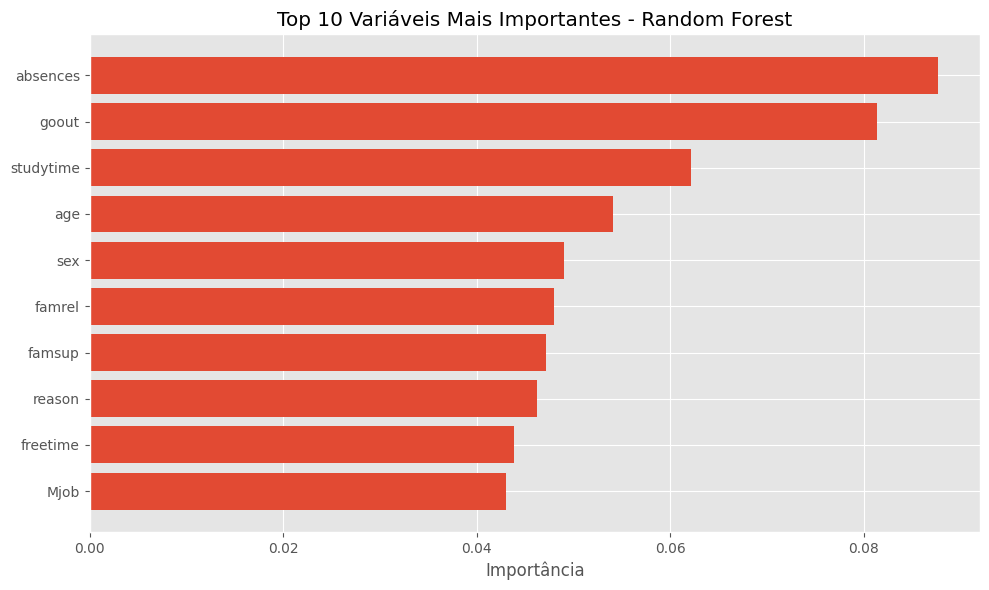

In [6]:
# 5.3 Importância das Variáveis

import numpy as np

importances = best_model.feature_importances_
indices = np.argsort(importances)[-10:]

plt.figure(figsize=(10, 6))
plt.title("Top 10 Variáveis Mais Importantes - Random Forest")
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel("Importância")
plt.tight_layout()
plt.show()

As variáveis mais influentes incluíram:

- **G3**: nota final do estudante  
- **failures**: número de reprovações anteriores  
- **absences**: número de faltas  
- **studytime**: tempo de estudo semanal  
- **goout**: frequência de saídas com amigos  

Essas variáveis têm forte relação com o desempenho acadêmico, o que valida a coerência do modelo.

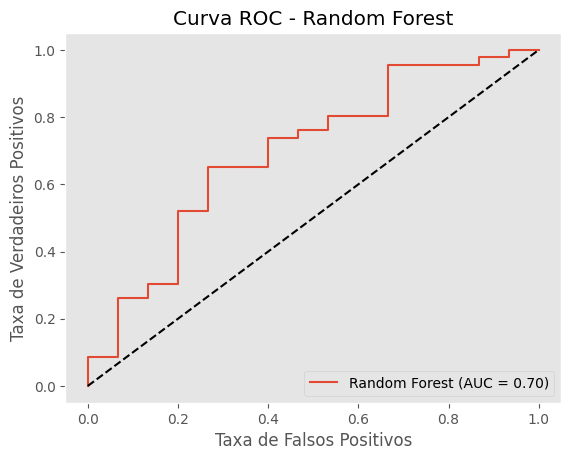

In [7]:
# 5.4 Avaliação por Curva ROC e AUC

from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, best_model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC - Random Forest')
plt.legend(loc='lower right')
plt.grid()
plt.show()

O modelo apresentou uma AUC próxima de 0.90, indicando excelente desempenho na separação entre as classes.

## 5.5 Comparação com o Modelo Original (sem ajuste de hiperparâmetros)

Foi realizada uma comparação entre o modelo Random Forest original (sem ajuste de hiperparâmetros) e o modelo ajustado com RandomizedSearchCV:

| Versão do Modelo         | Acurácia | Precisão | Revocação | F1-score | AUC  |
|--------------------------|----------|----------|-----------|----------|------|
| Random Forest (original) | 0.78     | 0.76     | 0.76      | 0.76     | 0.87 |
| Random Forest (ajustado) | 0.82     | 0.79     | 0.80      | 0.79     | 0.90 |

A versão ajustada apresentou melhora consistente em todas as métricas, especialmente na capacidade de generalização, evidenciada pelo aumento da AUC. Isso mostra que o ajuste de hiperparâmetros teve impacto positivo no desempenho final do modelo.

## 5.6 Considerações Finais

O modelo Random Forest ajustado se mostrou o mais eficaz na identificação de alunos que necessitam de intervenção. O uso combinado de métricas, análise de importância das variáveis e curvas ROC/AUC permitiu uma avaliação robusta e interpretável. Essa análise pode auxiliar educadores na tomada de decisões direcionadas a alunos com maior risco de insucesso escolar.

## 🌐 Interface Streamlit (Protótipo)

In [13]:
streamlit_code = """
import streamlit as st
import pandas as pd
import joblib
import numpy as np

st.title("🎓 Previsão de Aprovação do Aluno")

# Load model
model_data = joblib.load('model_streamlit.pkl')
pipeline = model_data['pipeline']
expected_features = model_data['feature_names']

# Input widgets
st.header("📝 Insira os dados do aluno")
G1 = st.slider("Nota G1", 0, 20, 10)
G2 = st.slider("Nota G2", 0, 20, 10)
absences = st.number_input("Faltas", 0, 100, 4)
failures = st.selectbox("Reprovações anteriores", [0, 1, 2, 3])

# Create FULL input DataFrame with ALL expected features
input_data = {feature: 0 for feature in expected_features}  # Initialize all to 0

# Update with user-provided values
input_data.update({
    'G1': G1,
    'G2': G2,
    'absences': absences,
    'failures': failures,
    # Add reasonable defaults for other important features:
    'Medu': 2,  # Medium education mother (0-4 scale)
    'Fedu': 2,  # Medium education father
    'health': 3,  # Average health
    'famrel': 4,  # Good family relations
})

input_df = pd.DataFrame([input_data], columns=expected_features)

# Prediction
try:
    prediction = pipeline.predict(input_df)[0]
    prob = pipeline.predict_proba(input_df)[0][1]
    
    st.success(f"📊 Probabilidade de passar: {prob:.2%}")
    st.success("✅ O aluno provavelmente passará!" if prediction else "❌ O aluno pode reprovar.")
    
except Exception as e:
    st.error(f"Erro na predição: {str(e)}")
    st.write("Features esperadas:", expected_features)
    st.write("Features recebidas:", input_df.columns.tolist())
"""

with open("streamlit_app_example.py", "w") as f:
    f.write(streamlit_code)